In [1]:
%matplotlib notebook

# 导入需要用的一些包，定义函数

In [31]:
# load packages
import os
import astropy.io.fits as fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy import units as u
import numpy as np
import scipy.ndimage.filters as filters
import scipy.interpolate as interpol
from astropy.coordinates import SkyCoord, Galactic
import matplotlib as mpl
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

In [3]:
# define functions
def wcs_2d_from_header(h_):
    h = {k: h_[k] for k in h_}
    h['NAXIS'] = 2
    h['WCSAXES'] = 2
    for k in ['NAXIS3', 'CRPIX3', 'CDELT3', 'CUNIT3', 'CTYPE3',
              'CRVAL3', 'CROTA3',
              'NAXIS4', 'CRPIX4', 'CDELT4', 'CUNIT4', 'CTYPE4',
              'CRVAL4', 'CROTA4',
              'VELREF', 'HISTORY']:
        if k in h:
            h.pop(k)
    return WCS(h)


def xy_from_wcs(w):
    x, y = np.meshgrid(np.arange(w._naxis1), np.arange(w._naxis2))
    return w.wcs_pix2world(x, y, 0)


def minmax(*args):
    for a in args:
        print(a.min(), a.max())
    return


def interp_from_f(f, xx, yy):
    z_interp = np.zeros_like(xx)
    nrow, ncol = xx.shape
    for i in range(nrow):
        for j in range(ncol):
            z_interp[i,j] = f(yy[i,j], xx[i,j])
    return z_interp


def cosine_similarity(x, y, nan_as_zero=False):
    x_, y_ = x.flatten(), y.flatten()
    if nan_as_zero:
        x_[np.isnan(x_)] = 0.0
        y_[np.isnan(y_)] = 0.0
    return (np.dot(x_, y_) / 
            np.sqrt(np.dot(x_, x_)*
                    np.dot(y_, y_)))


def cosine_similarity_with_smooth(x, y, box=10):
    if box <= 1:
        return cosine_similarity(x, y, nan_as_zero=True)
    return cosine_similarity(filters.gaussian_filter(x, box),
                             filters.gaussian_filter(y, box), nan_as_zero=True)


def get_channel_similarity(dcube, box=10):
    nd = dcube.shape[0]
    simi = np.zeros((nd, nd)) + np.nan

    for i in range(nd-1):
        simi[i,i] = 1.0
        for j in range(0,i):
            simi[i,j] = cosine_similarity_with_smooth(
                dcube[i,:,:], dcube[j,:,:], box=box)
            simi[j,i] = simi[i,j]
    return simi


def match_plot(data_f, data_m,
               cslice=None, islice=None,
               box=1, normalize_u=False,
               wcs=None):
    cdata = np.sum(data_f[cslice,...], axis=0)[islice]
    mtrace = [np.sum(data_m[i][islice]) for i in range(len(data_m))]
    simi = [cosine_similarity_with_smooth(cdata,
                                          data_m[i][islice],
                                          box=box)
            for i in range(len(data_m))]
    if normalize_u:
        simi = [simi[i]*mtrace[i] for i in range(len(simi))]
    
    isorted = sorted([_ for _ in enumerate(simi)], key=lambda x: -x[1])
    imax = isorted[0][0]

    fig = plt.figure(figsize=(8,5))

    ax = fig.add_subplot(2,2,1)
    ax.plot(simi, marker='o', markersize=3)
    ax.axvline(x=imax, color='red', linestyle='--')
    ax.xaxis.set_ticklabels([])
    ax.text(0.9, 0.9, 'Similarity', horizontalalignment='right', transform=ax.transAxes)

    ax = fig.add_subplot(2,2,3)
    ax.plot(mtrace, marker='o', markersize=3)
    ax.axvline(x=imax, color='red', linestyle='--')
    ax.set_xlabel('DistMod')
    ax.text(0.9, 0.9, 'Integrated Extinction', horizontalalignment='right', transform=ax.transAxes)

    ax = fig.add_subplot(2,2,2, projection=wcs[islice])
    ax.imshow(cdata, origin='lower')
    ax.text(0.5,0.9, '$^{12}$CO channel = '+'{:d} - {:d}'.format(cslice.start, cslice.stop-1),
            color='white', horizontalalignment='center', transform=ax.transAxes)
    ax.coords[0].set_ticklabel_visible(False)
    ax.coords[1].set_ticks_position('lr')
    ax.coords[1].set_ticklabel_position('r')
    for c in ax.coords:
        c.ticks.set_color('white')

    ax = fig.add_subplot(2,2,4, projection=wcs[islice])
    ax.imshow(data_m[imax][islice], origin='lower')
    ax.text(0.5,0.9, 'DistMod channel = '+'{:d}'.format(imax),
            color='white', horizontalalignment='center', transform=ax.transAxes)
    ax.set_xlabel('$l$')
    ax.set_ylabel('$b$')
    ax.coords[1].set_ticks_position('lr')
    ax.coords[1].set_ticklabel_position('r')
    ax.coords[1].set_axislabel_position('r')
    for c in ax.coords:
        c.ticks.set_color('white')

    fig.subplots_adjust(hspace=0.05, wspace=0.05, left=0.1, right=0.9)
    return


def get_group_from_simi(simi, simi_threshold=0.3, nChan_threshold=3):
    n = simi.shape[0]
    groups = []
    ibg = 0
    while True:
        for i in range(ibg+1,n):
            if simi[ibg, i] < simi_threshold:
                break
        ied = i
        if ied - ibg >= nChan_threshold:
            groups.append((ibg, ied))
        ibg = ied + 1
        if ibg > n - nChan_threshold:
            break
    return groups


def sum_and_smooth(a, sl_=None, box=10, nanval=0.0):
    b = np.sum(a[sl_[0]:sl_[1],...], axis=0)
    b[np.isnan(b)] = nanval
    return filters.gaussian_filter(b, box)


def get_regions(a, area_threshold=0, lv_threshold=0.05, box=1):
    if box >= 1:
        z = filters.gaussian_filter(a, box)
    else:
        z = a
    alev = a.max() * lv_threshold
    fig = plt.figure(figsize=(0.01,0.01))
    ax = fig.add_subplot(1,1,1)
    ctr = ax.contour(z, np.array([alev]))
    plt.close(fig)
    del fig
    return get_level_paths(ctr, alev, area_threshold=area_threshold)


def get_level_paths(ctr, lv, area_threshold=0):
    imin = np.argmin(np.abs(ctr.levels - lv))
    a = ctr.collections[imin]
    p_s = a.get_paths()
    return [p for p in p_s if get_path_area(p) > area_threshold]


def PolyArea(x, y):
    #https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))


def PolyArea_2D(a):
    x,y = a[:,0], a[:,1]
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))


def get_path_area(p):
    return PolyArea_2D(p.vertices)


def get_region_bbox(r):
    x,y = r.vertices[:,0], r.vertices[:,1]
    return [int(_) for _ in (x.min(), x.max(), y.min(), y.max())]

# 导入数据

In [4]:
working_dir = '/Users/fjdu/distance/'

In [469]:
hdu = fits.open(os.path.join(working_dir, 'DeltaEBV.fits'))
header = hdu[0].header
wcs_dust = wcs_2d_from_header(header)
data_dust = hdu[0].data
data_dust.shape

(31, 1441, 2041)

In [470]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 2041                                                  
NAXIS2  =                 1441                                                  
NAXIS3  =                   31                                                  
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =              14521.0 / Pixel coordinate of reference point            
CRPIX2  =                721.0 / Pixel coordinate of reference point            
CRPIX3  =                  1.0 / Pixel coordinate of reference point            
CDELT1  =  -0.0083333333333333 / [deg] Coordinate increment at reference point  
CDELT2  =   0.0083333333333333 / [deg] Coordinate increment at reference point  
CDELT3  =                  0

In [6]:
hdu = fits.open(os.path.join(working_dir, 'G105U_reb_clip.fits'))
header = hdu[0].header
wcs_12CO = wcs_2d_from_header(header)
data_12CO = hdu[0].data
data_12CO.shape

(341, 1261, 1801)

## 根据fits文件信息制作x、y坐标矩阵

In [7]:
x_dust,y_dust = xy_from_wcs(wcs_dust)
x_12CO,y_12CO = xy_from_wcs(wcs_12CO)
minmax(x_dust,y_dust,x_12CO,y_12CO)
print(x_dust[0,:])
print(y_dust[:,0])
x_dust[0,-1::-1].shape, y_dust[:,0].shape, data_dust[7,:,:].shape

103.99999999999959 120.99999999999952
-5.999999999999976 5.999999999999976
104.7499999999581 119.74999999995211
-5.2499999999979 5.2499999999979
[121.         120.99166667 120.98333333 ... 104.01666667 104.00833333
 104.        ]
[-6.         -5.99166667 -5.98333333 ...  5.98333333  5.99166667
  6.        ]


((2041,), (1441,), (1441, 2041))

# 对尘埃数据插值

## 测试插值结果

In [8]:
intf = interpol.RectBivariateSpline(y_dust[:,0], x_dust[0,-1::-1], data_dust[7,:,-1::-1])
z_interp = interp_from_f(intf, x_dust, y_dust)
minmax(z_interp)

6.717218639096001e-06 0.021160511299967773


0.9999995031691806
0.07730875704447043
0.8650042330477824


<IPython.core.display.Javascript object>


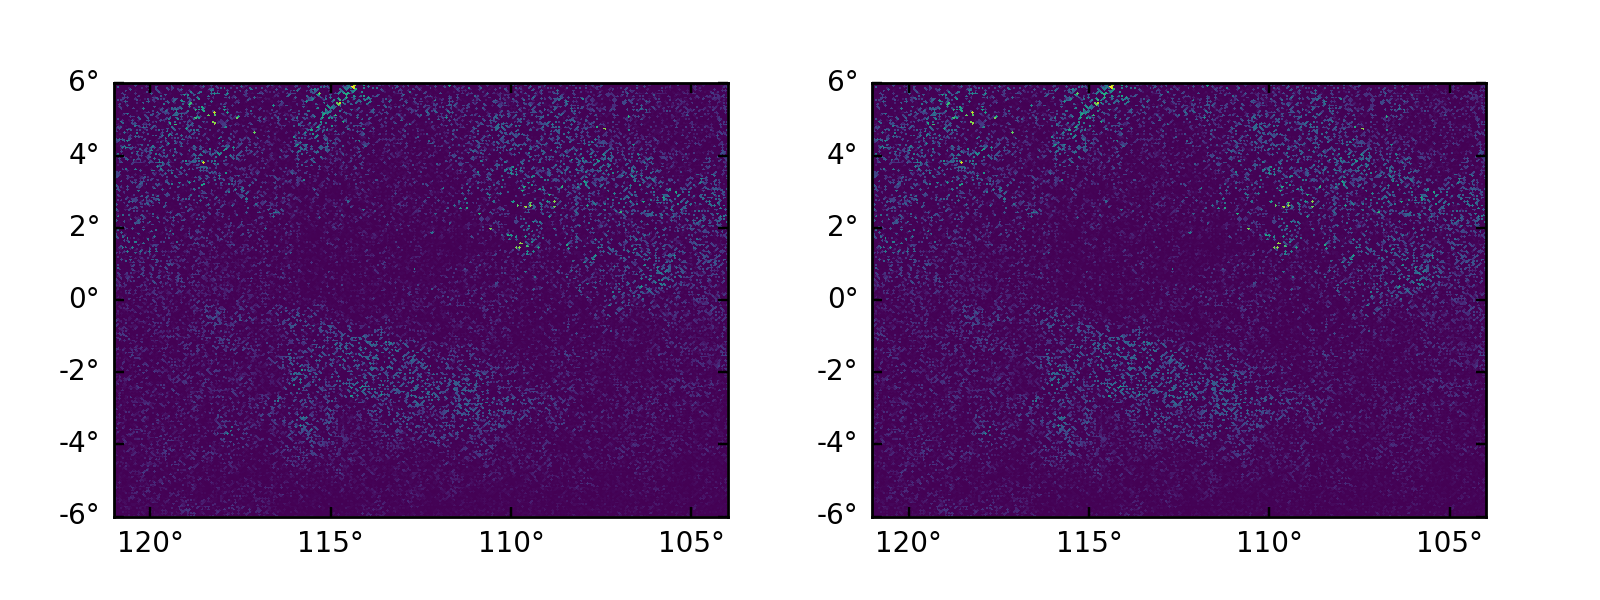

In [10]:
print(cosine_similarity(z_interp, data_dust[7,:,:]))
print(cosine_similarity(z_interp, data_dust[8,:,:]))
print(cosine_similarity(filters.gaussian_filter(z_interp,10),
                        filters.gaussian_filter(data_dust[8,:,:], 10)))

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1,2,1, projection=wcs_dust)
ax.imshow(z_interp, origin='lower')
ax = fig.add_subplot(1,2,2, projection=wcs_dust)
ax.imshow(data_dust[7,:,:], origin='lower')
fig.tight_layout(pad=3)

## 将尘埃数据全部插值到CO数据的空间位置上

In [11]:
fname = os.path.join(working_dir, 'data_dust_12CO.npy')
if os.path.exists(fname):
    data_dust_12CO = np.load(fname)
else:
    data_dust_12CO = [interp_from_f(interpol.RectBivariateSpline(y_dust[:,0],
                                                                 x_dust[0,-1::-1],
                                                                 data_dust[i,:,-1::-1]),
                                    x_12CO, y_12CO)
                      for i in range(data_dust.shape[0]-1)]
    np.save(fname, data_dust_12CO)

### 比较插值所得数据和原始数据

<IPython.core.display.Javascript object>


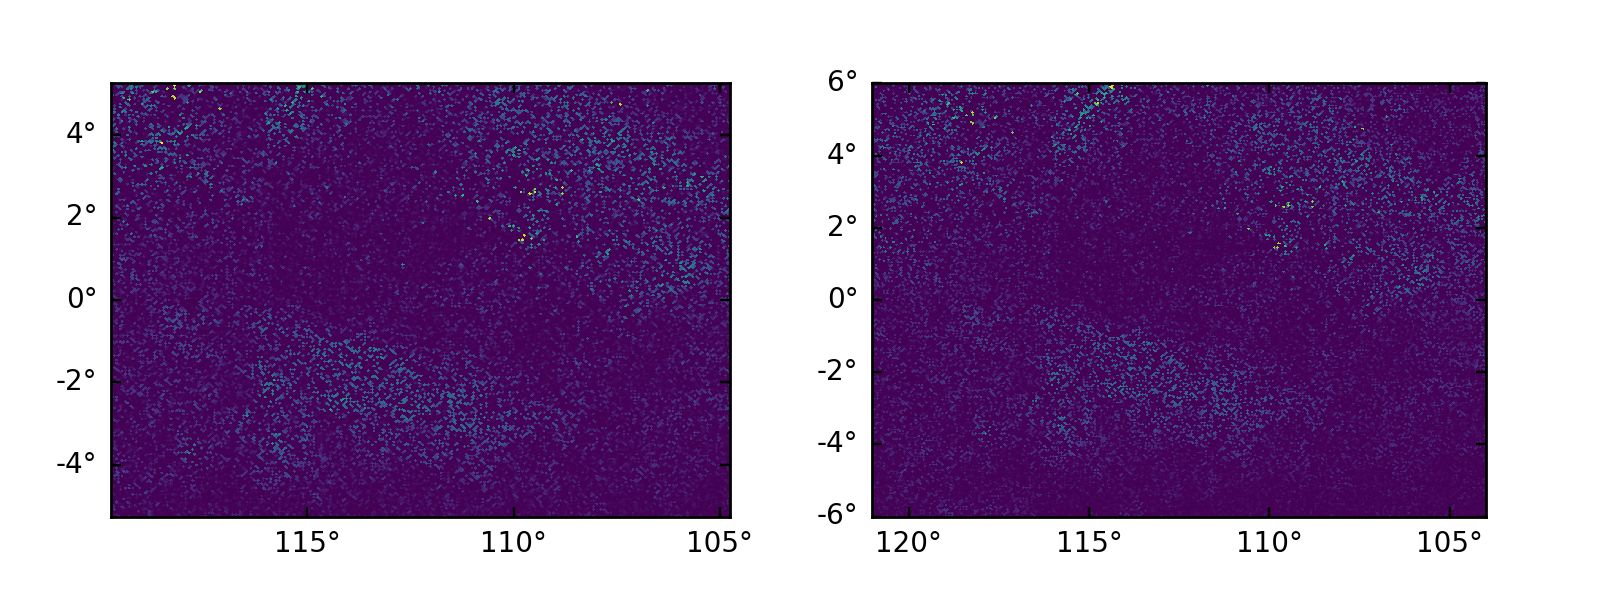

In [12]:
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1,2,1, projection=wcs_12CO)
ax.imshow(data_dust_12CO[7], origin='lower')
ax = fig.add_subplot(1,2,2, projection=wcs_dust)
ax.imshow(data_dust[7,:,:], origin='lower')
fig.tight_layout(pad=3)

# 搜索与CO图像最相似的尘埃图像

$$\newcommand\simi{{\rm simi}}$$

## 相似度的定义


对于两个数组$A$和$B$，这里把它们的相似度定义为
$$\simi(A,B) \equiv \frac{A\cdot B}{\left(A\cdot A\right)^{1/2} \left(B\cdot B\right)^{1/2}}.$$

可以看到，$\simi(A,A)=1$.

如果$A$和$B$的元素是在0到1之间均匀分布的独立随机数，则当它们包含的元素个数较多时，$\simi(A,B)\simeq \frac{3}{4}.$

如果$A$和$B$的元素以几率$p$取1、几率$(1-p)$取0，则$\simi(A,B)\simeq p.$

## 根据相似度寻找匹配的尘埃图

对于每个CO的速度通道范围，计算CO的积分强度图，寻找与之最相似的尘埃图。

下面的`cslice`参数表示CO的速度通道范围，`islice`表示CO图的x和y方向的像素范围。

`Similarity`子图表示不同尘埃图与CO图的相似度。横坐标是尘埃图的序号（相当于距离模数）。

`Integrated Extinction`子图表示在`islice`区域内尘埃的总消光随着距离模数的变化。

红线表示最佳匹配的尘埃图序号（距离模数）。

<IPython.core.display.Javascript object>


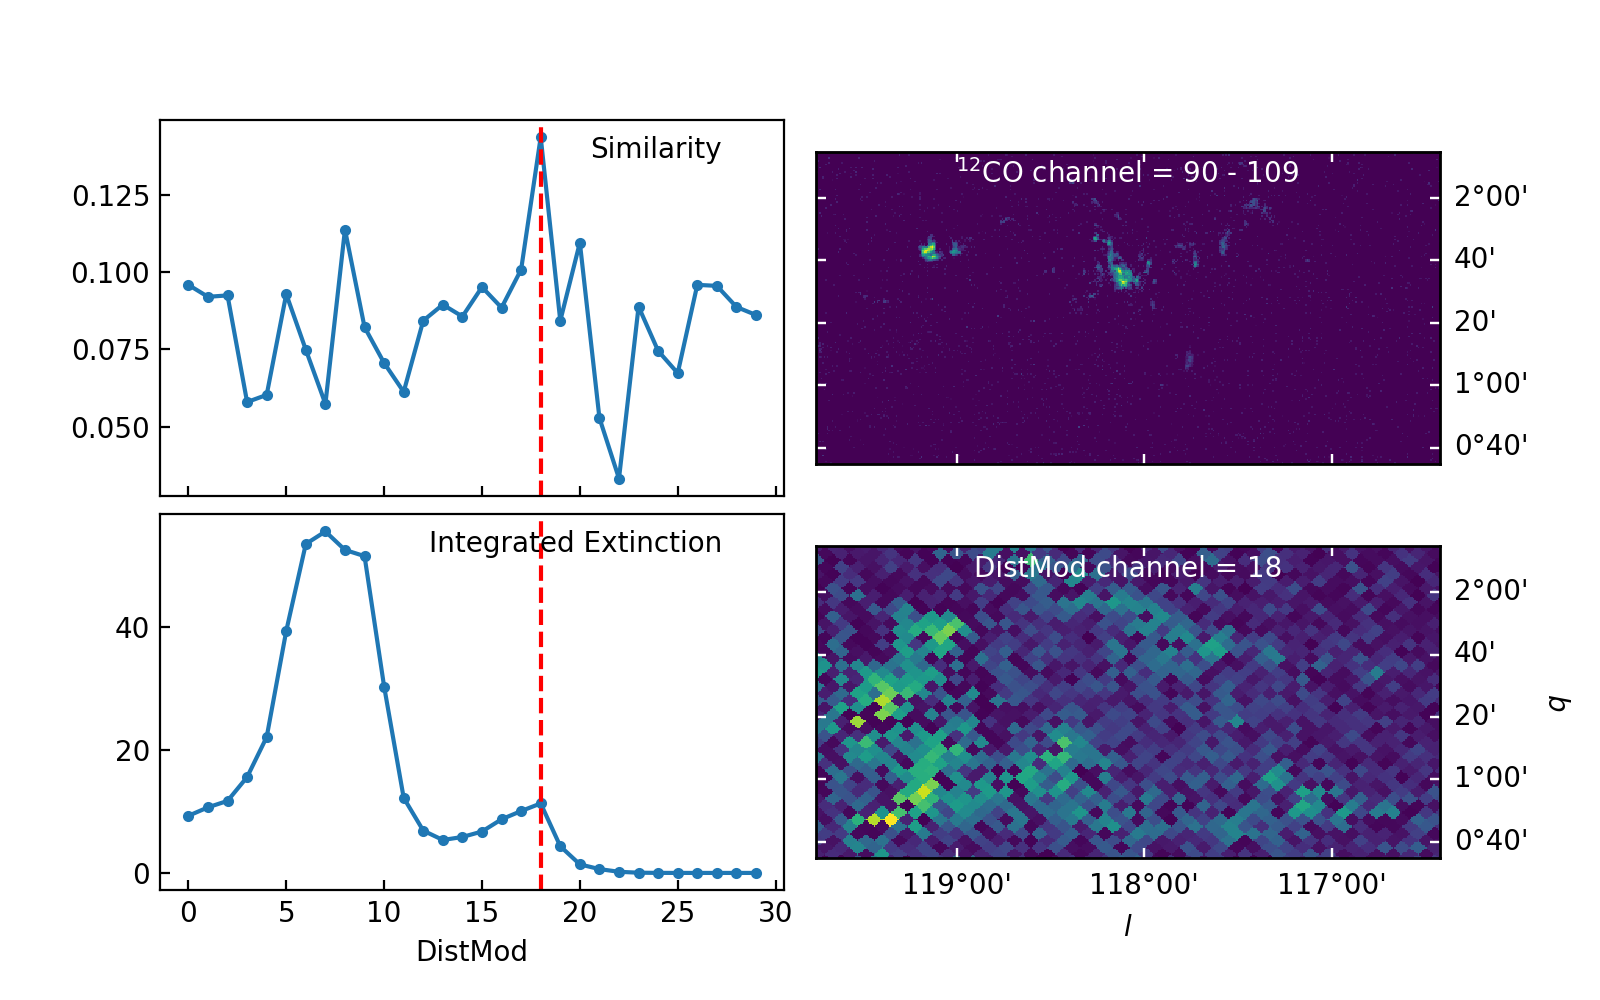

In [13]:
match_plot(data_12CO, data_dust_12CO,
           cslice=np.s_[90:110], islice=np.s_[700:900,0:400], wcs=wcs_12CO)

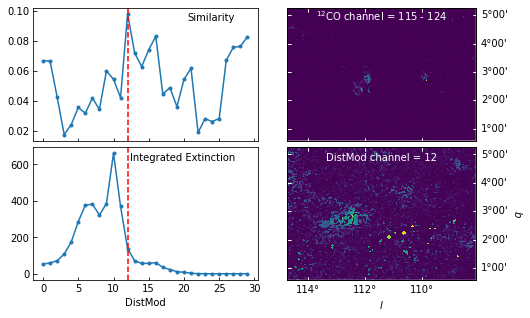

In [555]:
match_plot(data_12CO, data_dust_12CO,
           cslice=np.s_[115:125], islice=np.s_[700:1300,600:1400], wcs=wcs_12CO)

<IPython.core.display.Javascript object>


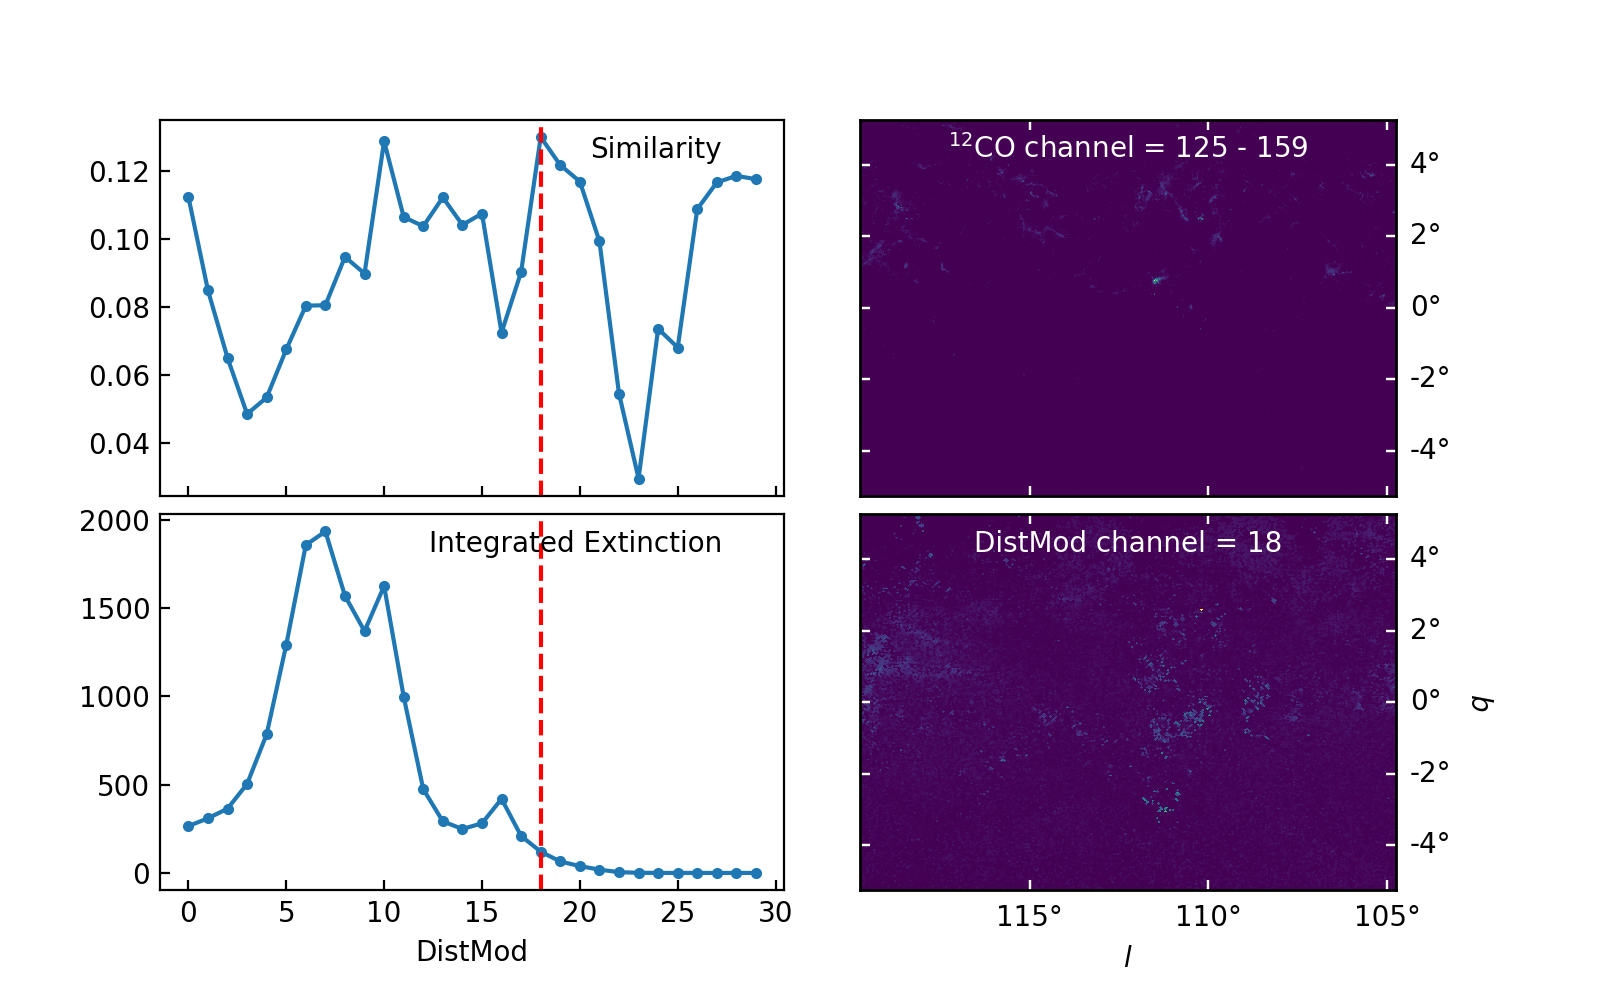

In [14]:
match_plot(data_12CO, data_dust_12CO,
           cslice=np.s_[125:160], islice=np.s_[:,:], wcs=wcs_12CO)

<IPython.core.display.Javascript object>


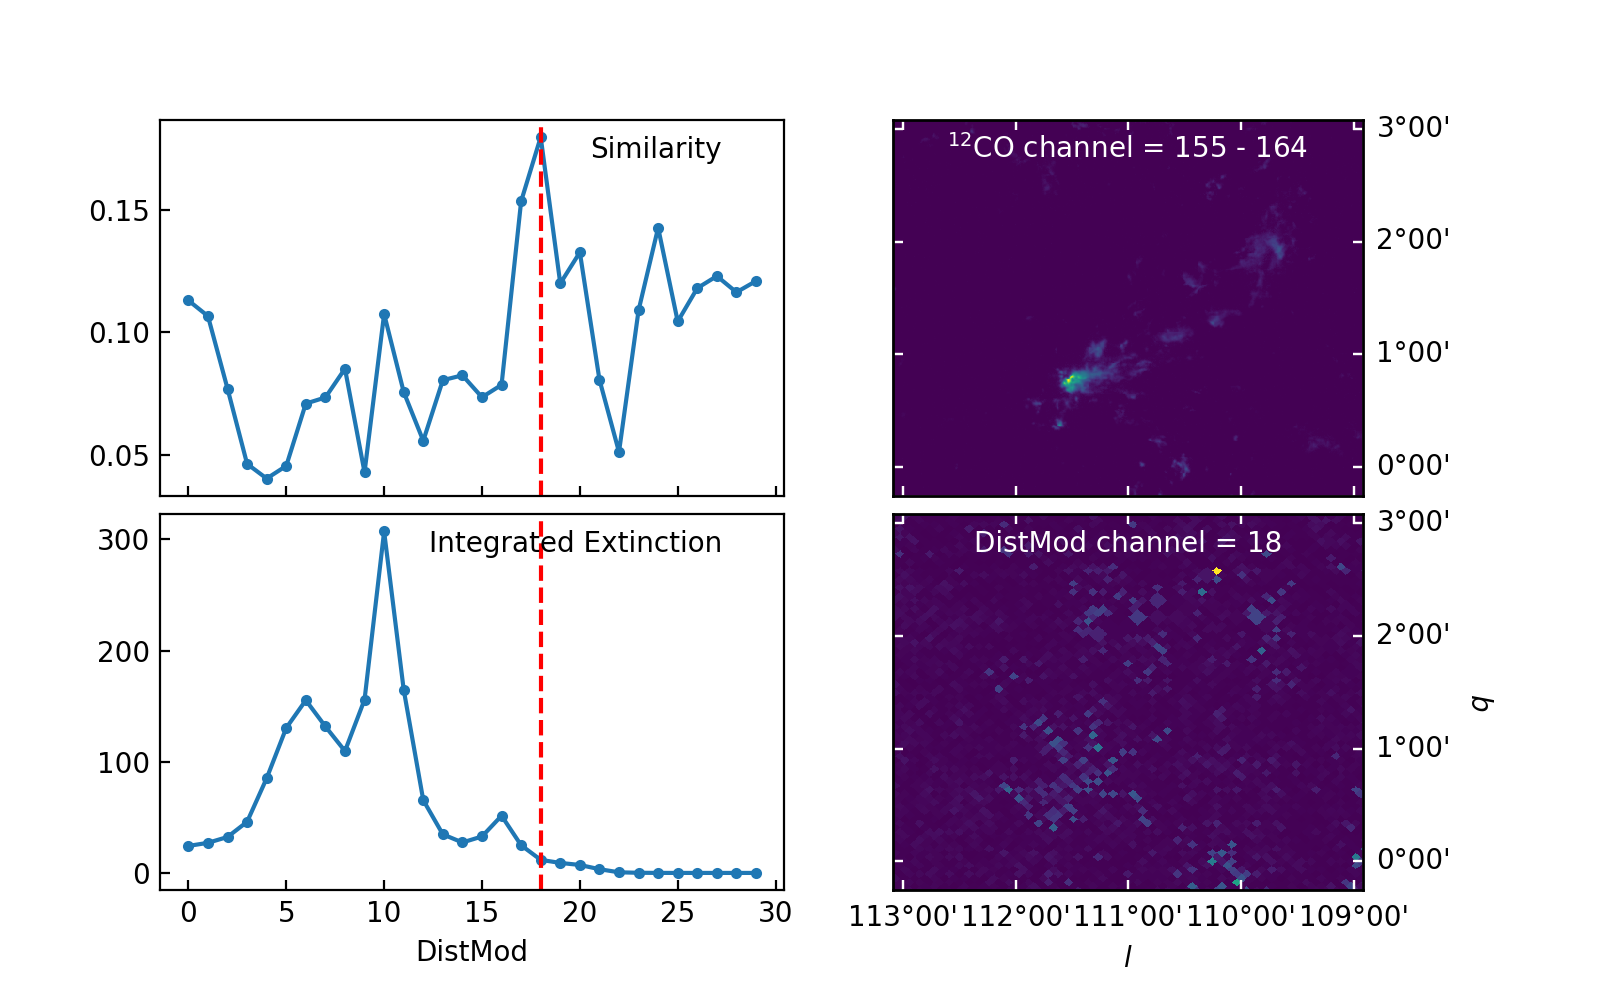

In [15]:
match_plot(data_12CO, data_dust_12CO,
           cslice=np.s_[155:165], islice=np.s_[600:1000, 800:1300], wcs=wcs_12CO)

<IPython.core.display.Javascript object>


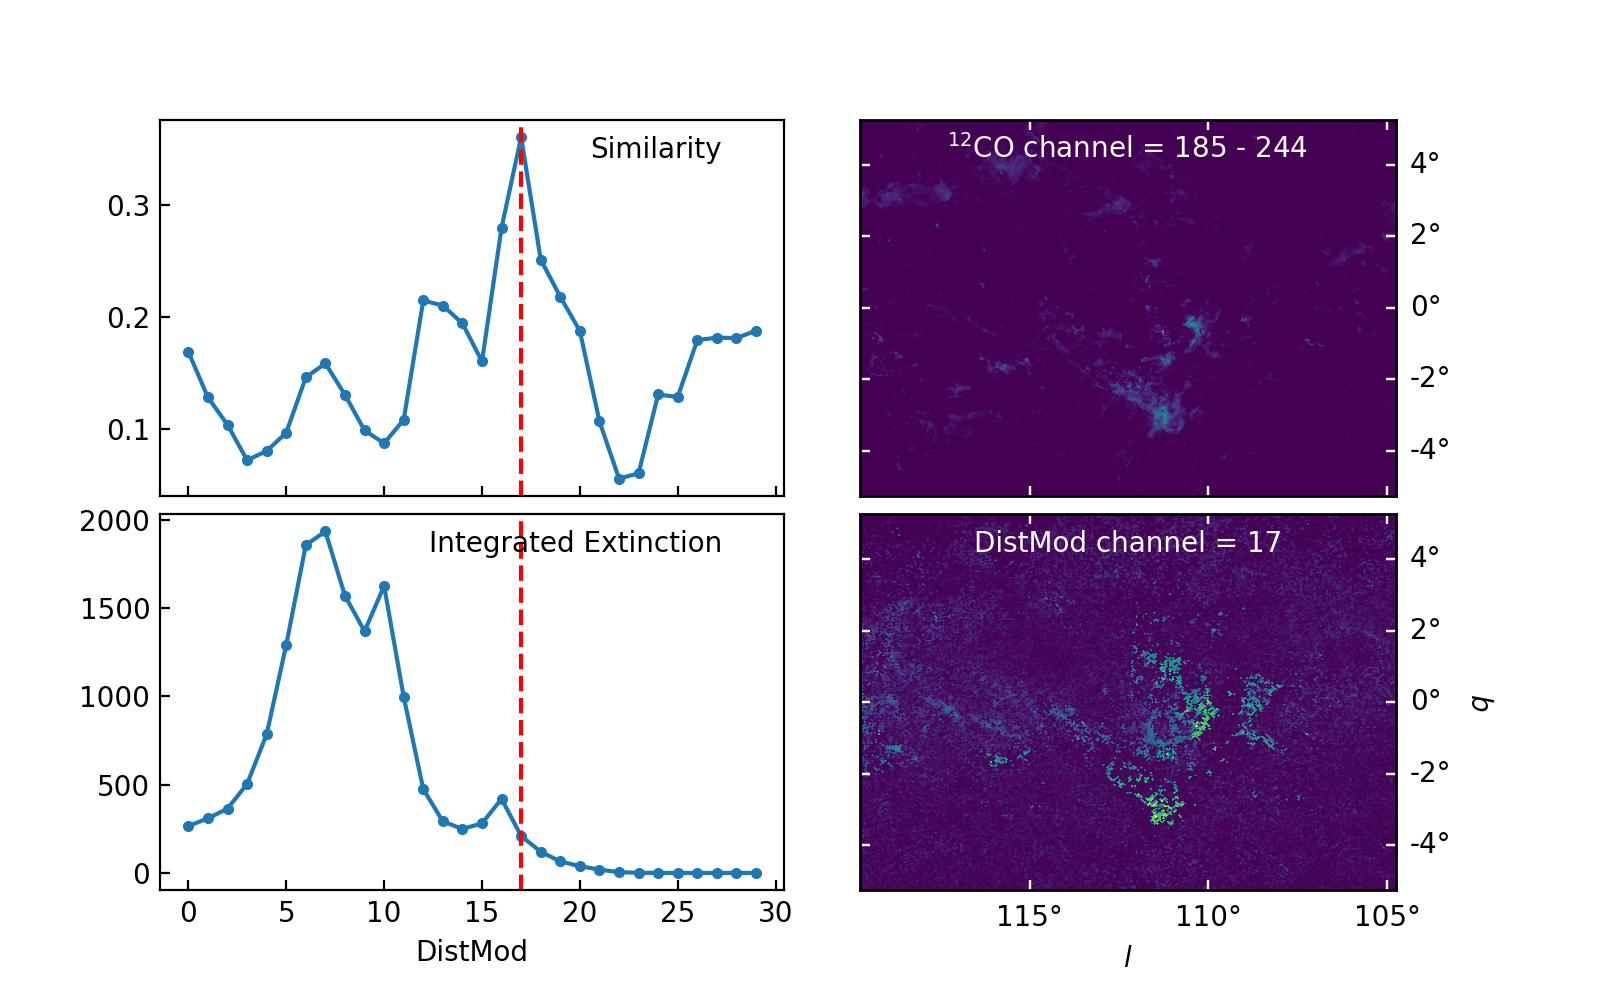

In [16]:
match_plot(data_12CO, data_dust_12CO,
           cslice=np.s_[185:245], islice=np.s_[:,:], wcs=wcs_12CO)

<IPython.core.display.Javascript object>


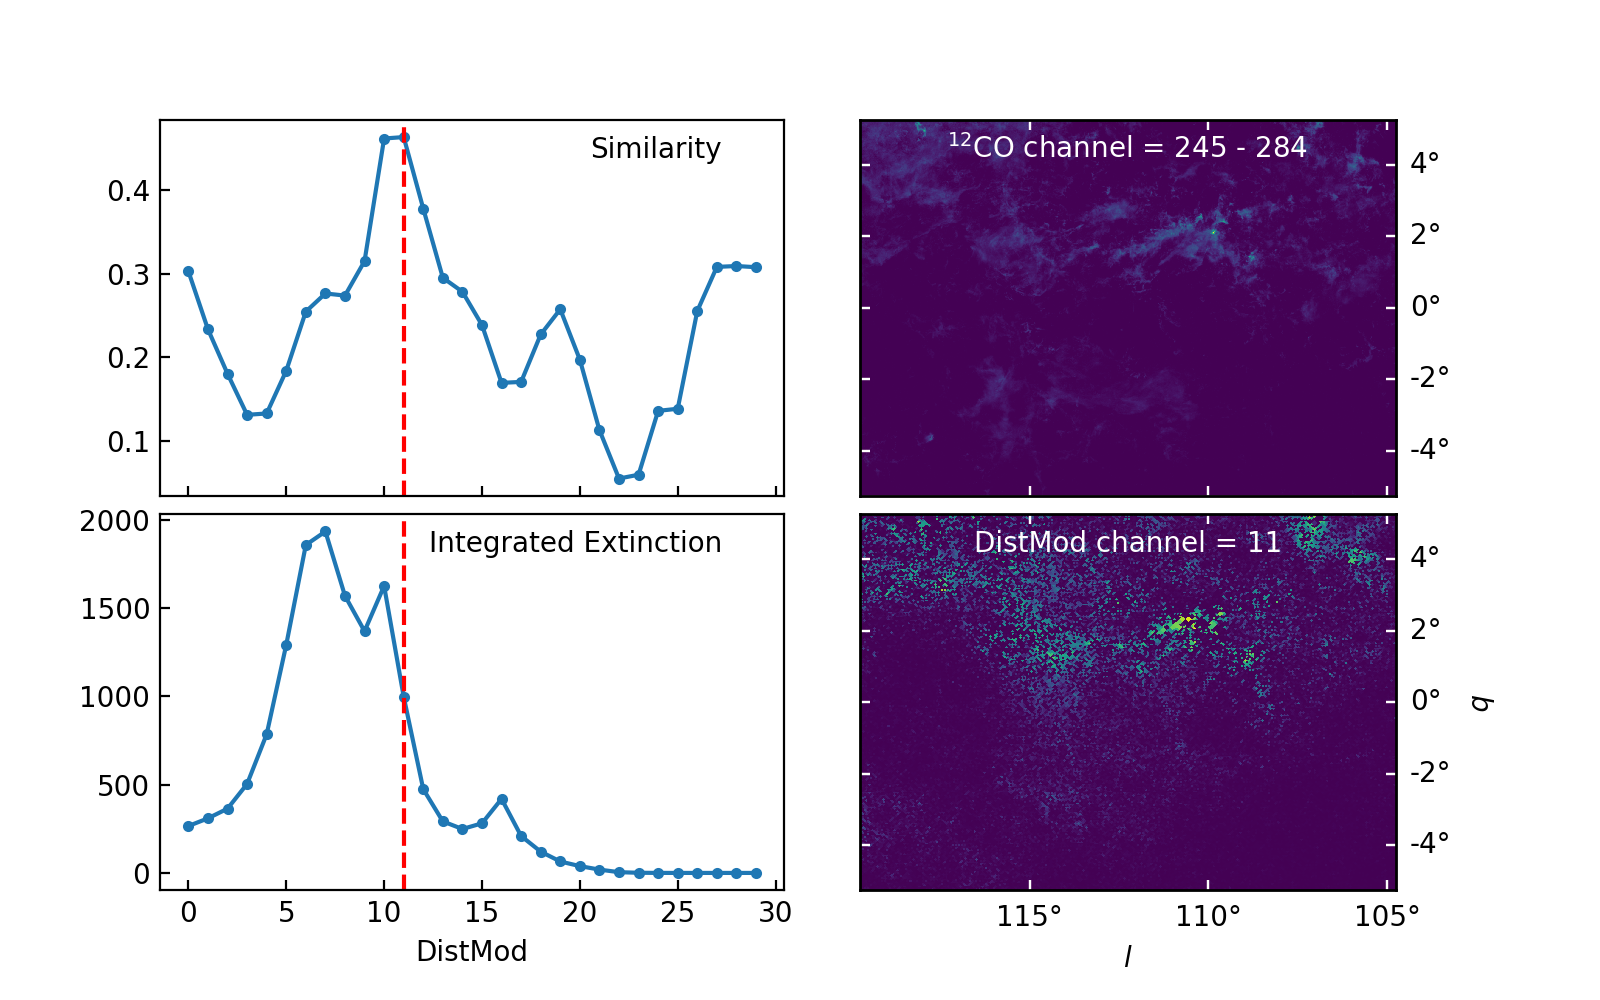

In [17]:
match_plot(data_12CO, data_dust_12CO,
           cslice=np.s_[245:285], islice=np.s_[:,:], wcs=wcs_12CO)

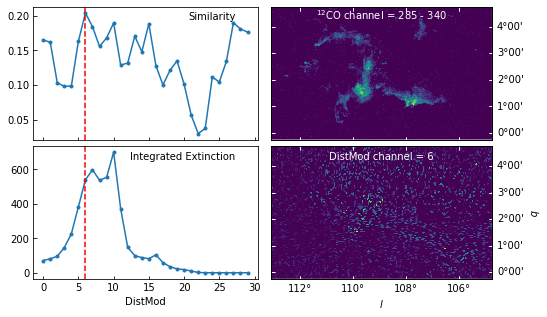

In [560]:
match_plot(data_12CO, data_dust_12CO,
           cslice=np.s_[285:341], islice=np.s_[600:1200,800:], wcs=wcs_12CO)

<IPython.core.display.Javascript object>


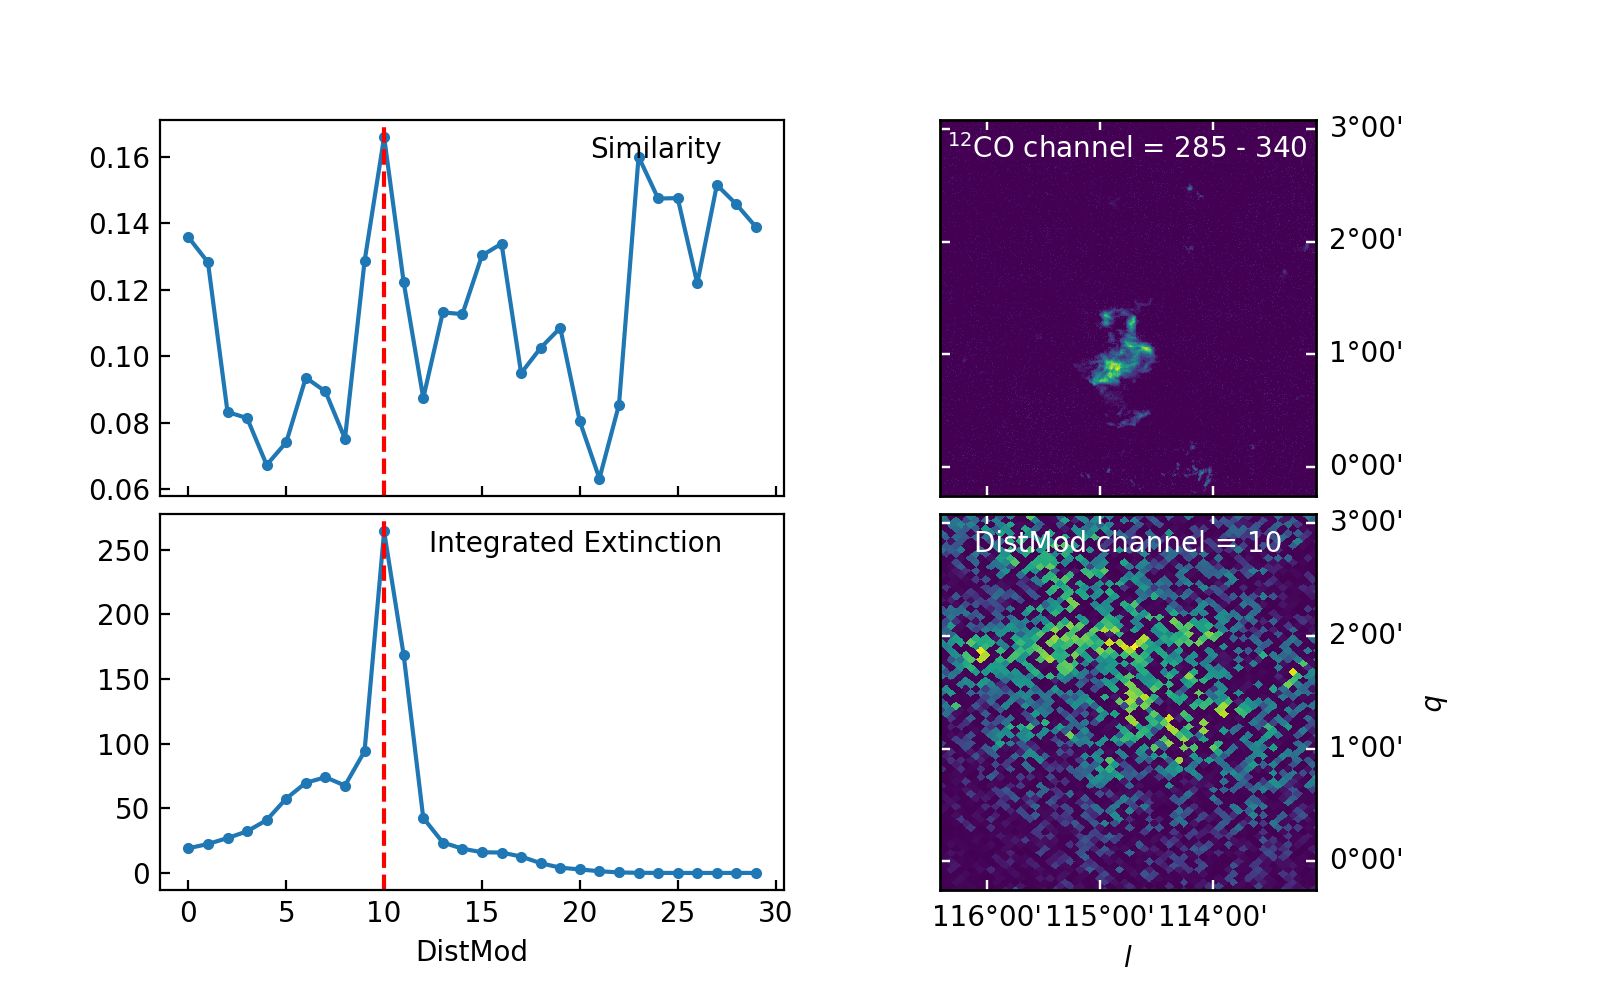

In [18]:
match_plot(data_12CO, data_dust_12CO,
           cslice=np.s_[285:341], islice=np.s_[600:1000,400:800], wcs=wcs_12CO)

# 通过相似度寻找结构

对于一个datacube，比如叫做$A$，它有三个下标：`A[i,j,k]`。假设第一个下标代表某种“channel”，后两个下标代表像素。

第`i1`和第`i2`个channel的相似度定义为
$$simi(i_1,i_2) \equiv simi(A[i1,:,:], A[i2,:,:])$$

## 尘埃数据不同距离模数之间的相似度

In [20]:
fname = os.path.join(working_dir, 'simi_dust.npy')
if os.path.exists(fname):
    simi_dust = np.load(fname)
else:
    simi_dust = get_channel_similarity(data_dust, box=10)
    np.save(fname, simi_dust)

<IPython.core.display.Javascript object>


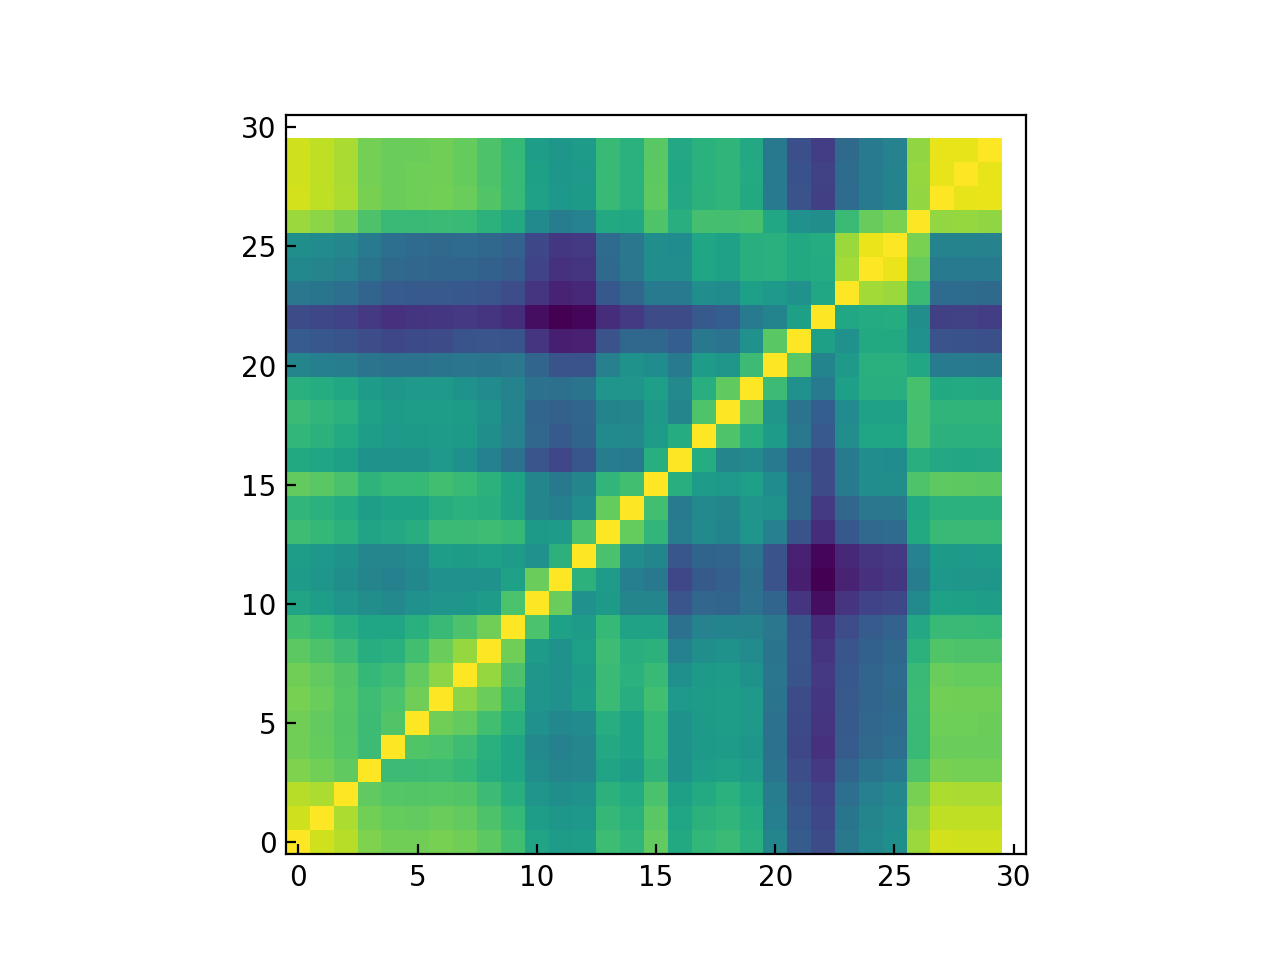

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(simi_dust, origin='lower')

## CO数据不同channel之间的相似度

In [22]:
fname = os.path.join(working_dir, 'simi_12CO.npy')
if os.path.exists(fname):
    simi_12CO = np.load(fname)
else:
    simi_12CO = get_channel_similarity(data_12CO[:,:,:], box=5)
    np.save(fname, simi_12CO)

<IPython.core.display.Javascript object>


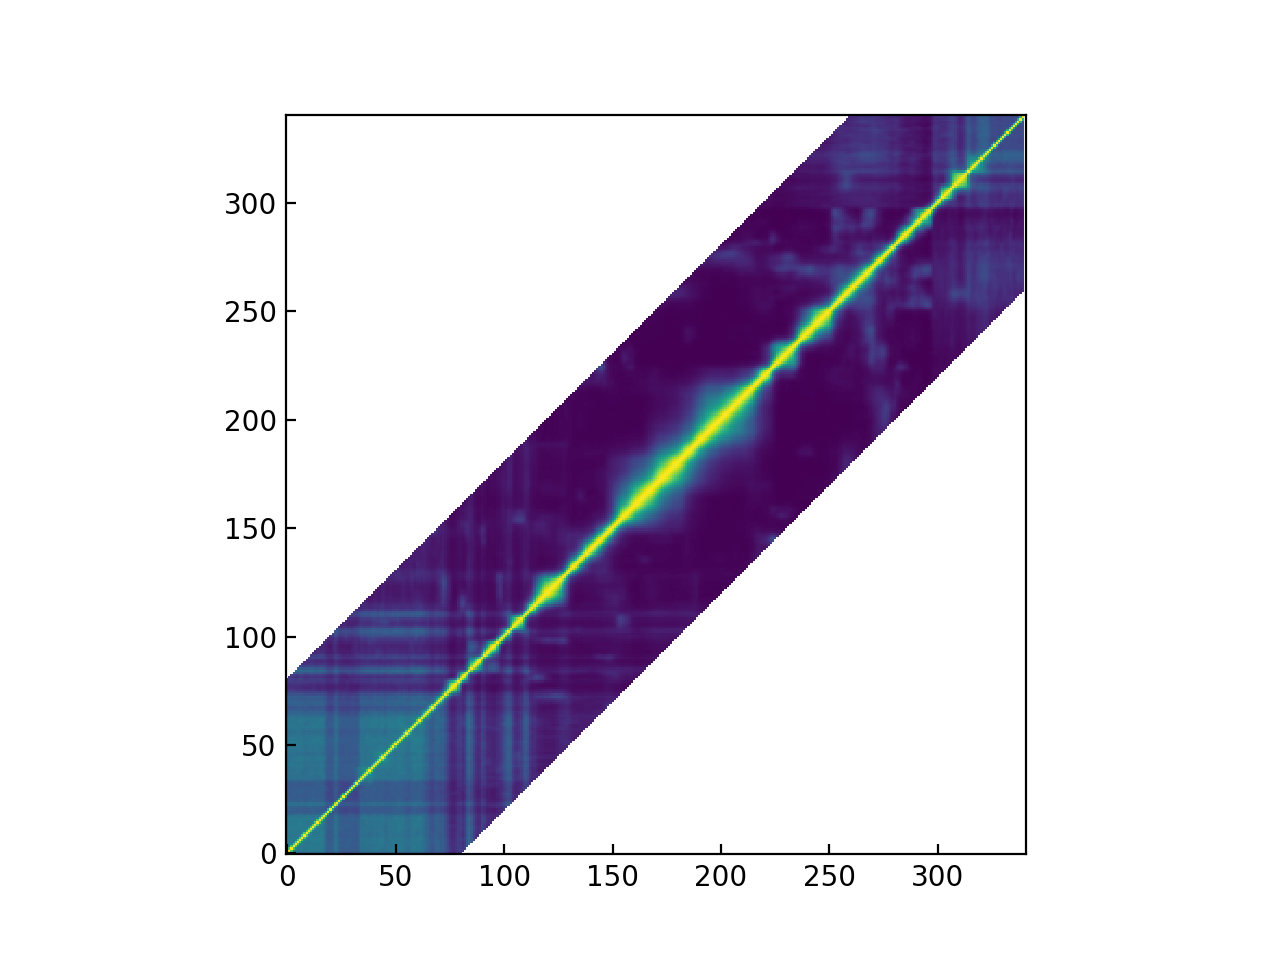

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(simi_12CO[:,:], origin='lower')

### 通过相似度在速度轴分层

In [24]:
groups_12CO = get_group_from_simi(simi_12CO)
print(groups_12CO)
print(len(groups_12CO))

[(0, 18), (22, 25), (32, 40), (41, 66), (67, 72), (73, 77), (78, 81), (82, 85), (86, 91), (92, 98), (99, 103), (104, 110), (111, 116), (117, 128), (129, 134), (135, 141), (142, 148), (149, 155), (156, 171), (172, 187), (188, 202), (203, 216), (217, 224), (225, 235), (236, 244), (245, 253), (254, 261), (262, 269), (270, 275), (276, 280), (281, 286), (287, 292), (293, 298), (299, 303), (304, 309), (310, 315), (316, 323)]
37


### 对于每个速度层，找出空间结构

In [ ]:
regions = [
    get_regions(sum_and_smooth(data_12CO, sl_=s_, box=10), lv_threshold=0.1, area_threshold=2e3, box=1)
    for s_ in groups_12CO
]

In [26]:
regions= [sorted(rs, key=lambda x: -get_path_area(x)) for rs in regions]

In [27]:
sum([len(r) for r in regions])

237

<IPython.core.display.Javascript object>


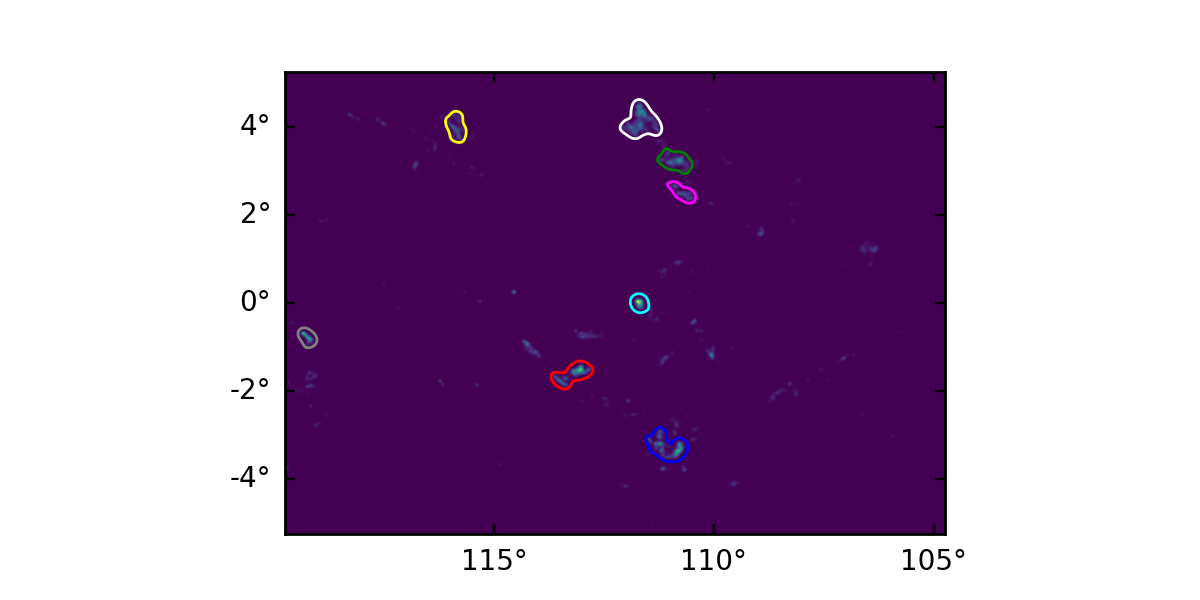

0.10880533893895661
8


<IPython.core.display.Javascript object>


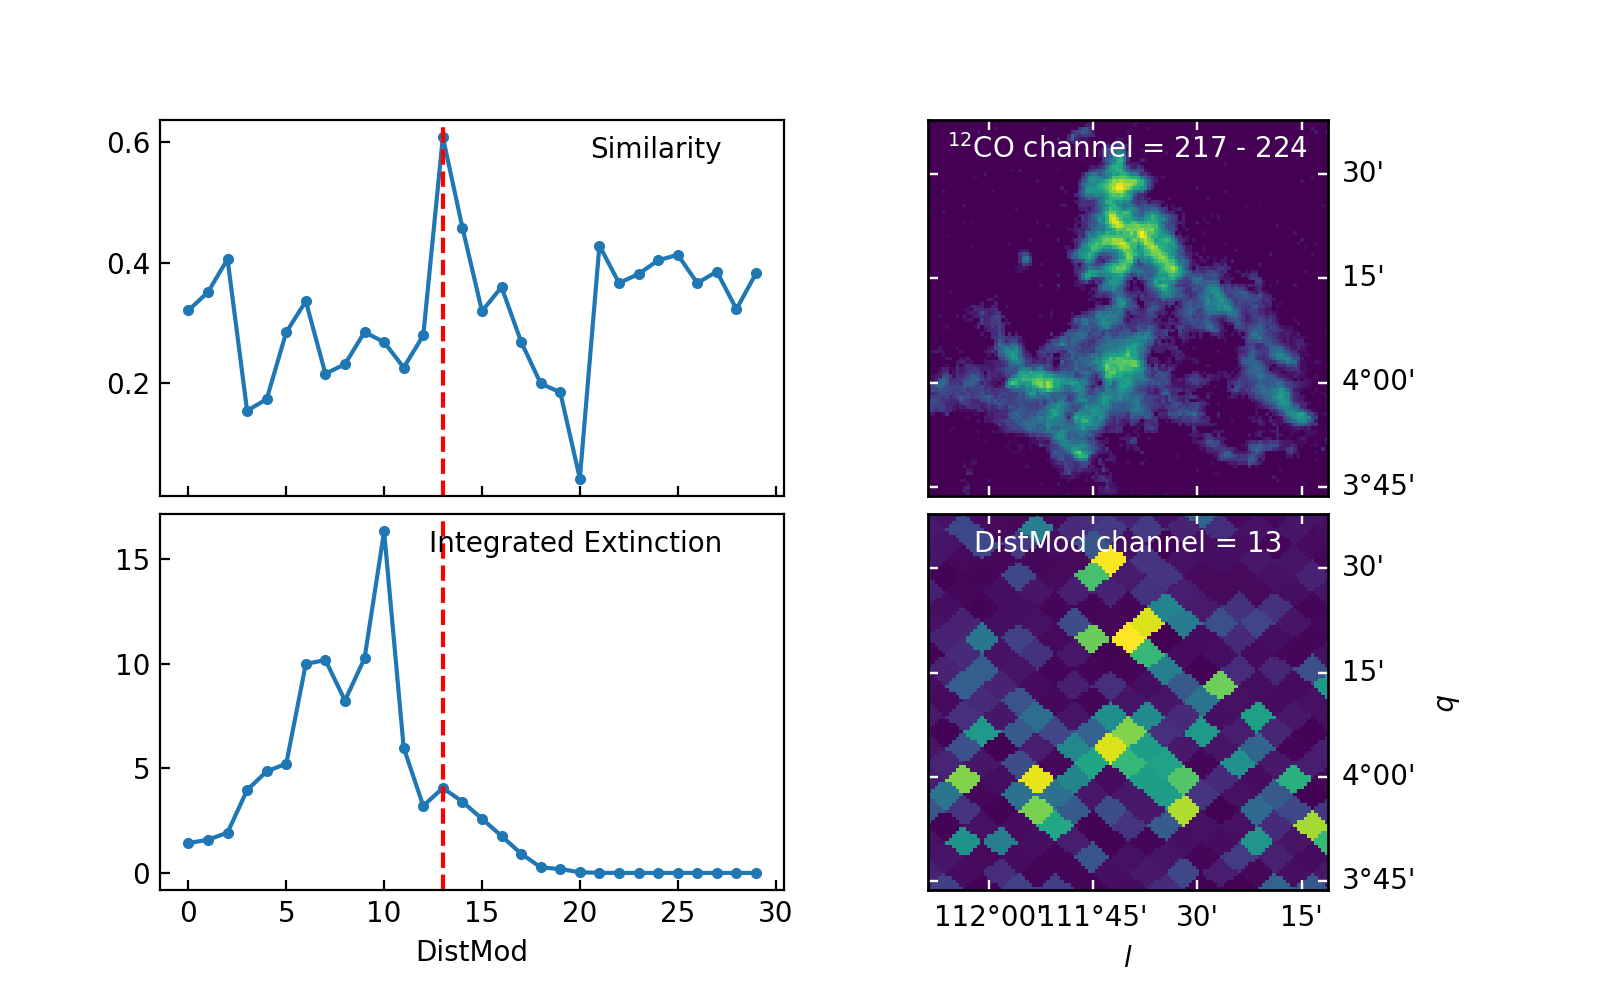

In [28]:
ig = 22
ic = 0
box = 3

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1,1,1, projection=wcs_12CO)
z = sum_and_smooth(data_12CO, sl_=groups_12CO[ig], box=box)
ax.imshow(z, origin='lower')
print(cosine_similarity(z, np.random.rand(*z.shape)))

colors = ['white', 'blue', 'red', 'green', 'yellow', 'magenta', 'cyan', 'grey']

nregion = len(regions[ig])
print(nregion)

if nregion > 0:
    for i in range(nregion):
        p_ = regions[ig][i]
        plg = plt.Polygon(p_.vertices, facecolor='none', edgecolor=colors[i % len(colors)])
        ax.add_patch(plg)

    g = groups_12CO[ig]
    r = get_region_bbox(regions[ig][ic])

    match_plot(data_12CO, data_dust_12CO, wcs=wcs_12CO, normalize_u=False,
               cslice=np.s_[g[0]:g[1]+1], islice=np.s_[r[2]:r[3]+1,r[0]:r[1]+1])

In [472]:
10**(10.75/5+1)

1412.537544622754

0.045488060332632446 25.72150909311047


<IPython.core.display.Javascript object>


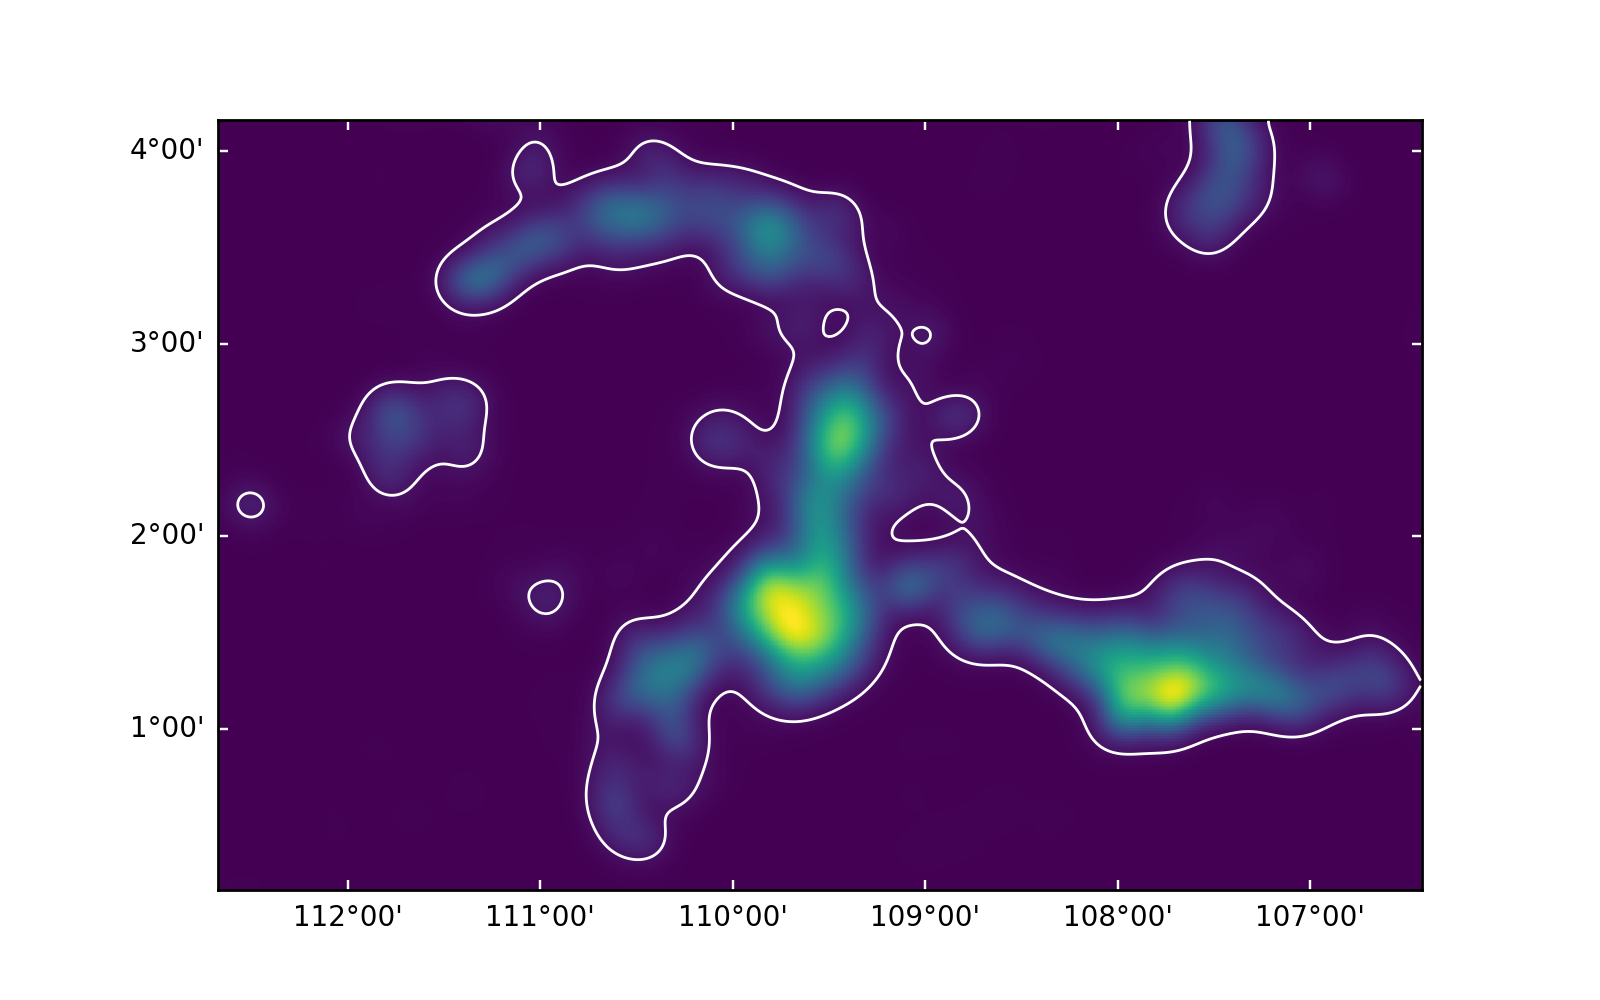

In [117]:
cslice=np.s_[285:341]
islice=np.s_[650:1130,850:1600]

z = sum_and_smooth(data_12CO, sl_=(285,341), box=10)[islice]
minmax(z)
zmax = z.max()

box = 5
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1, projection=wcs_12CO[islice])
ax.imshow(z, origin='lower')
ctr = ax.contour(filters.gaussian_filter(z, 5), np.array([0.05])*zmax,
                 colors='white', linewidths=1)
for c in ax.coords:
    c.ticks.set_color('white')

In [154]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
import skimage.filters
def detect_ridges(gray, sigma=3.0):
    hxx, hyy, hxy = hessian_matrix(gray, sigma, order="rc")
    i1, i2 = hessian_matrix_eigvals([hxx, hxy, hyy])
    return i1, i2

In [146]:
u = z[:,1:] - z[:,:-1]
v = z[1:,:] - z[:-1,:]

u = np.hstack((u, np.nan+np.zeros((u.shape[0], 1))))
v = np.vstack((np.nan+np.zeros((1, v.shape[1])), v))

<IPython.core.display.Javascript object>


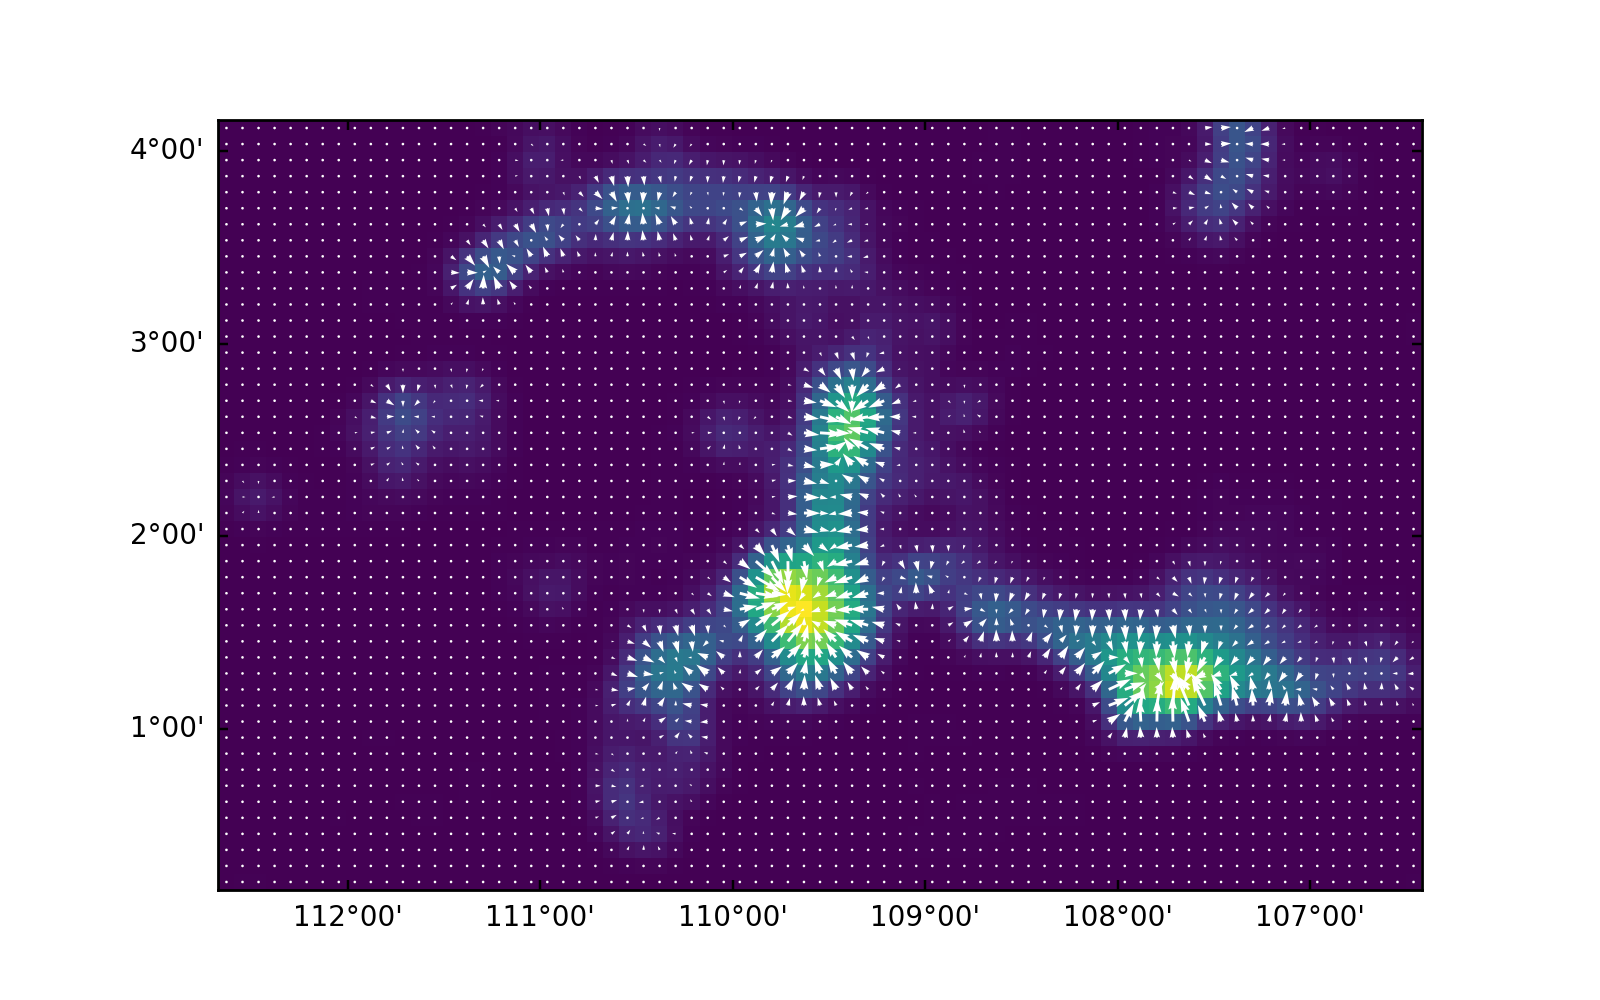

In [152]:
s = 10
u,v = skimage.filters.sobel_h(z), skimage.filters.sobel_v(z)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1, projection=wcs_12CO[650:1130:s,850:1600:s])
ax.imshow(z[::s,::s], origin='lower')
ax.quiver(v[::s,::s], u[::s,::s], units='xy', scale=1, color='white')

In [168]:
idx = np.logical_and(np.abs(x)<1e-5, y < -1e-5)
w = np.zeros_like(x)
w[idx] = 1.0

<IPython.core.display.Javascript object>


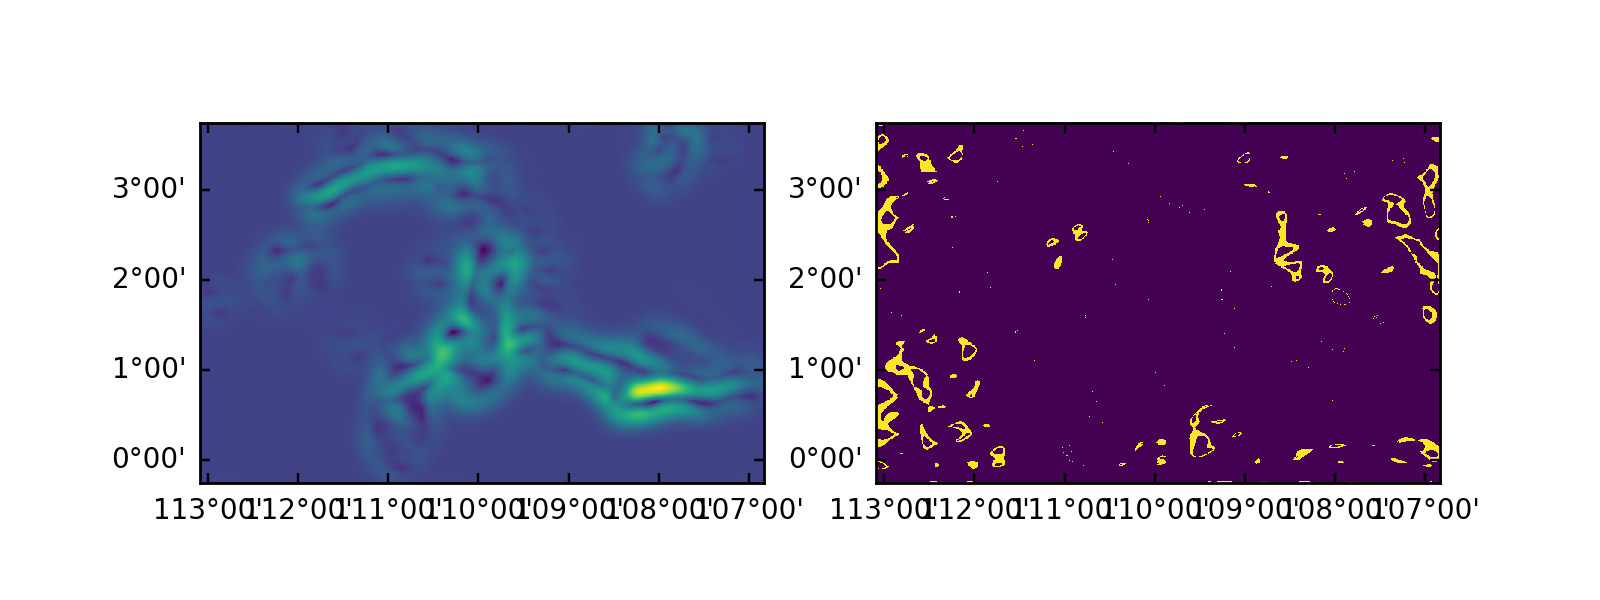

In [169]:
x,y = detect_ridges(z, sigma=10.0)
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1,2,1, projection=wcs_12CO[600:1200,800:1700])
ax.imshow(x, origin='lower')
ax = fig.add_subplot(1,2,2, projection=wcs_12CO[600:1200,800:1700])
ax.imshow(w, origin='lower')

# 附录：随机矩阵之间的相似度

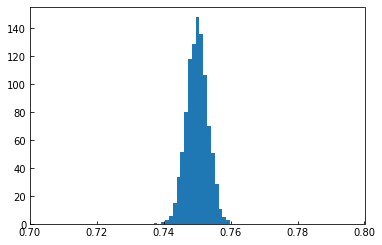

In [567]:
n = 100
v = [cosine_similarity(np.random.rand(n,n), np.random.rand(n,n)) for i in range(1000)]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlim((0.7,0.8))
_ = ax.hist(v, bins=20)

In [464]:
def f(x,y):
    return np.sin(x) - y

def df(x,y):
    return (np.cos(x), -np.ones_like(y))

def newton(g, dg, x, y):
    dg_ = dg(x, y)
    dgm = dg_[0]**2 + dg_[1]**2
    return (x - g(x, y) * dg_[0] /  dgm,
            y - g(x, y) * dg_[1] / dgm)